# Numerical simulation of 1D Reaction-Diffusion PDE
Here we add space and simulate the PDE of $A = A(x,y,t)$ subject to diffusion and a reaction $f = -dV/dA$.
$$\partial_t A = D \nabla^2 A + f(A)$$

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sympy as sp
import time

In [2]:
def extend_periodic_2D(v):
    """Add ghost columns for periodic BC along axis 1."""
    v_ext =  np.hstack([v[:, -1:], v, v[:, :1]])
    v_ext =  np.vstack([v_ext[-1:, :], v_ext, v_ext[:1, :]])
    return v_ext

def _rhs_2D(A,func, D, dx,dy):
    """
    Deterministic RHS for reaction-diffusion system in 2D, with reaction them fun and diffusion coeficent D
    Returns dAdt.
    """
    A_e = extend_periodic_2D(A);
    
    # centered diffusion (Laplacian), reactions
    diffusion_A_dx =   (D/(dx**2))*(A_e[ 2:,1:-1] - 2.0*A_e[1:-1,1:-1] + A_e[0:-2,1:-1]);
    diffusion_A_dy =   (D/(dy**2))*(A_e[1:-1,2: ] - 2.0*A_e[1:-1,1:-1] + A_e[1:-1,0:-2]);
    diffusion_A = diffusion_A_dx + diffusion_A_dy
    reaction_A  =   func(A_e[1:-1,1:-1]);

    dAdt = diffusion_A + reaction_A
    
    return dAdt

def Stepper_Reaction_Diffusion_Euler_2D(A, func, D, dx, dy, dt):
    """
    One Forward Euler step for reaction diffusion system
    """
    dAdt   = _rhs_2D(A,func, D, dx,dy)
    A_next = A + dt*dAdt
    
    return A_next

def Stepper_Reaction_Diffusion_RK4_2D(A, func, D, dx, dy, dt):
    """
    One RK4 step for reaction diffusion system
    """
    k1 = _rhs_2D(A, func, D, dx,dy)
    k2 = _rhs_2D(A + 0.5*dt*k1, func, D, dx,dy)
    k3 = _rhs_2D(A + 0.5*dt*k2, func, D, dx,dy)
    k4 = _rhs_2D(A + dt*k3, func, D, dx,dy)

    # RK4 combine 
    A_next = A + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    return A_next

In [3]:
# Simulation

# Parameters
D       = 0.1 #diffusion coeficent
a_val   =  1  #reaction parameter a 
eps_val = 0.2 #reaction parameter epsilon  
params = {'a': a_val, 'eps': eps_val, 'D': D}

# Simulation parameters
dx = 0.1    # spatial reolution in x
dy = 0.1    # spatial reolution in x
dt = 0.01   # time step
T = 75      # total time
L = 30      # system length
sampling_time = 2.5 #times between samplings

# derived parameters
Mx = int(L/dx);  # number of lattice points in x
My = int(L/dy);  # number of lattice points in y
N  = int(T/dt);  # number of steps
n_samp =  max(int(sampling_time/dt),1);

#Defeniton of the evolution function
f = lambda x: -4*(a_val**2)*x*(x**2 - 1) - eps_val;

# Arrays to store results
A_state_2D  = np.zeros(shape = (Mx,My), dtype = np.float64) #The system state 
Sim_Data_2D = np.zeros(shape=(1,Mx,My), dtype = np.float64) #saved sim data
#inital conditions
x_co  = np.linspace(0, L, Mx) - L/2
y_co  = np.linspace(0, L, My) - L/2
x_2D,y_2D = np.meshgrid(x_co,y_co) 
r_2D = np.sqrt(x_2D**2 + y_2D**2) 
A0_2D = 1 - 2*np.exp(-0.25*(r_2D)**2)        #gaussian inital conditions
#A0_2D = -1 + 2*np.heaviside(r_2D - 1.25,0)    #step function inital conditions
#initate state and data matrix 
A_state_2D     = A0_2D;
Sim_Data_2D[0] = A0_2D;

#forward integration 
print(f'Simulation started, parameters = {params}')
wall_time_start = time.time()
for i in range(N-1):
    A_state_2D= Stepper_Reaction_Diffusion_RK4_2D(A_state_2D, f, D, dx, dy, dt) 
    if i%n_samp == 0: #save data every n_samp timesteps
        Sim_Data_2D = np.concatenate([Sim_Data_2D, A_state_2D[None, :, :]], axis=0)
    if i%((N)//10) == 0:  #print progress every 10%
        wall_time = time.time() - wall_time_start
        print(f'Progress {(i/N)*100 : 05}%. sim_time = {i*dt:4.1f}; wall_time = {wall_time:6.3f} [sec]')
wall_time = time.time() - wall_time_start
print(f'Progress 100% - Simulation done. Wall_Time = {wall_time/60:.2f} [min]')  

Simulation started, parameters = {'a': 1, 'eps': 0.2, 'D': 0.1}
Progress  00.0%. sim_time =  0.0; wall_time =  0.021 [sec]
Progress  10.0%. sim_time =  7.5; wall_time =  7.331 [sec]
Progress  20.0%. sim_time = 15.0; wall_time = 16.557 [sec]
Progress  30.0%. sim_time = 22.5; wall_time = 23.813 [sec]
Progress  40.0%. sim_time = 30.0; wall_time = 31.330 [sec]
Progress  50.0%. sim_time = 37.5; wall_time = 38.723 [sec]
Progress  60.0%. sim_time = 45.0; wall_time = 45.362 [sec]
Progress  70.0%. sim_time = 52.5; wall_time = 53.662 [sec]
Progress  80.0%. sim_time = 60.0; wall_time = 62.431 [sec]
Progress  90.0%. sim_time = 67.5; wall_time = 71.249 [sec]
Progress 100% - Simulation done. Wall_Time = 1.30 [min]


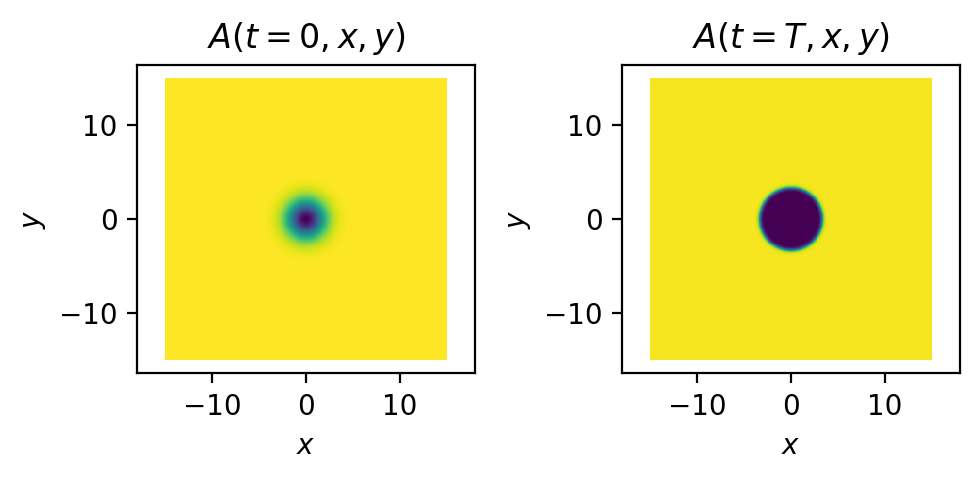

In [4]:
#plot inital and final states
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(5,2.5), dpi=200)
ax[0].pcolormesh(x_2D,y_2D,Sim_Data_2D[0],shading='nearest',vmin = -1, vmax = 1)
ax[1].pcolormesh(x_2D,y_2D,Sim_Data_2D[-1],shading='nearest',vmin = -1, vmax = 1)
ax[0].set_title('$A(t=0,x,y)$'); ax[0].set_xlabel('$x$'); ax[0].set_ylabel('$y$'); ax[0].axis('equal');
ax[1].set_title('$A(t=T,x,y)$'); ax[1].set_xlabel('$x$'); ax[1].set_ylabel('$y$'); ax[1].axis('equal');
plt.tight_layout()

Text(0.5, 1.0, 'Fronts - 2D (Horiz. Slice)')

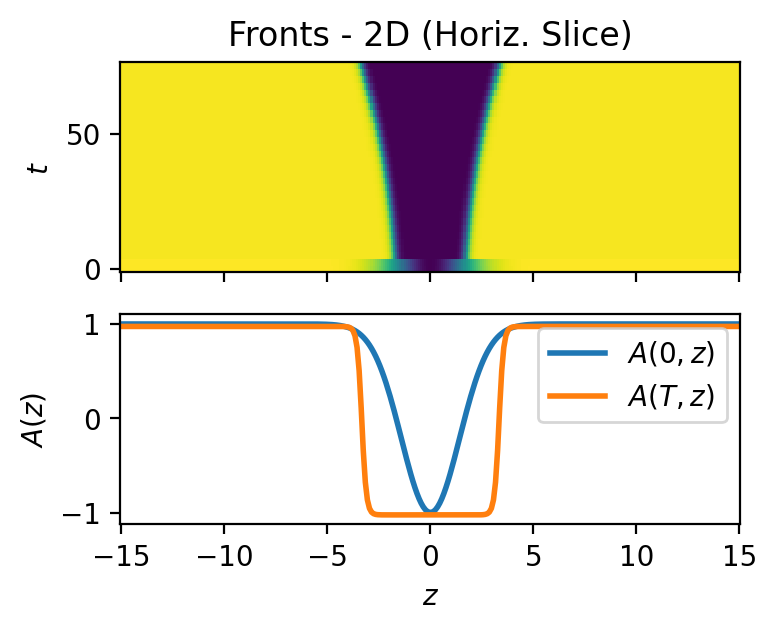

In [5]:
#plot the a horizontal slice
Sim_Data_2D_slice = Sim_Data_2D[:,:,Mx//2]

#make mesh grid
t_co  = np.linspace(0, T, Sim_Data_2D.shape[0])
t_tx_2D,x_tx_2D = np.meshgrid(t_co,x_co) 

fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(4,3), dpi=200, sharex = True)
ax[0].pcolormesh(x_tx_2D,t_tx_2D,Sim_Data_2D_slice.T,shading='nearest',vmin = -1, vmax = 1)
ax[1].plot(x_co, Sim_Data_2D_slice[0],  linewidth = 2, label = '$A(0,z)$')
ax[1].plot(x_co, Sim_Data_2D_slice[-1], linewidth = 2, label = '$A(T,z)$')

ax[0].set_ylabel('$t$')
ax[1].set_ylabel('$A(z)$')
ax[1].set_xlabel('$z$')
ax[1].legend()
ax[0].set_title('Fronts - 2D (Horiz. Slice)')    

Text(0.5, 0, '$t$')

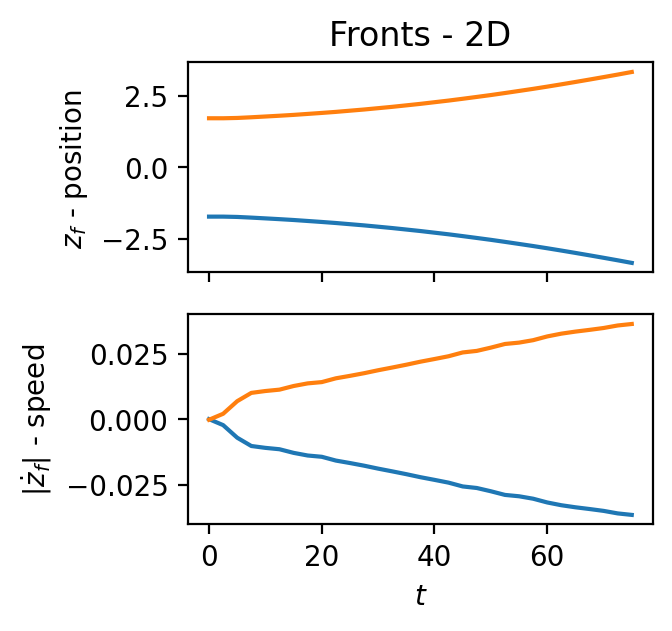

In [6]:
# front dynamics

from front_tracking import get_front_trajectories
#find front trajectories
front_value = 0.05; #value of A defining a front
d_max  = 0.5;  #maximum distance fo connected components
traj_list = get_front_trajectories(Sim_Data_2D_slice, x_co, front_value, d_max,sampling_time)

#Plot results
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(3,3), dpi=200, sharex = True)

for traj in traj_list:
    ax[0].plot(traj.t,traj.x)
    front_speed = (np.gradient(traj.x, traj.t))
    ax[1].plot(traj.t,front_speed)
ax[0].set_title('Fronts - 2D')    
ax[0].set_ylabel('$z_f$ - position ')
ax[1].set_ylabel('$|\\dot{z}_f|$ - speed')
ax[1].set_xlabel('$t$')


In [7]:
D/0.058 - 0.2

1.524137931034483

In [8]:
 D/0.058

1.7241379310344829